In [53]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-lon/London Property Listings Dataset.csv
/kaggle/input/data-def/UCI_Credit_Card.csv


In [54]:
# Импорт основных библиотек для работы:
# - warnings: отключаем ненужные предупреждения
# - pandas/numpy: работа с данными
# - seaborn/matplotlib: визуализация
# Также фиксируем стиль графиков и random_state для воспроизводимости
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

RANDOM_STATE = 42

In [55]:
# Загружаем датасет кредитного скоринга UCI.
# Смотрим форму датафрейма и первые строки, чтобы понять структуру данных.

df = pd.read_csv('/kaggle/input/data-def/UCI_Credit_Card.csv')
print(df.shape)
df.head()

(30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [56]:
# ID - бесполезный идентификатор клиента, не несёт информации.
# Удаляем его перед анализом и обучением моделей.

df = df.drop(columns=['ID'])

In [ ]:
# В суммах выставленных счетов встречаются отрицательные значения.
# Клипуем такие значения к нулю - отрицательных платежей не бывает.

bill_cols = [f'BILL_AMT{i}' for i in range(1, 7)]
df[bill_cols] = df[bill_cols].clip(lower=0)

In [58]:
# Выводим описательную статистику по числовым признакам,
# чтобы выявить возможные выбросы, дисбалансы и специфику распределений.

df.describe().T

,count,mean,std,min,25%,50%,75%,max
LIMIT_BAL,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0
EDUCATION,30000.0,1.853133,0.790349,0.0,1.00,2.0,2.00,6.0
MARRIAGE,30000.0,1.551867,0.521970,0.0,1.00,2.0,2.00,3.0
AGE,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
PAY_0,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
PAY_2,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
PAY_3,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
PAY_4,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0
PAY_5,30000.0,-0.266200,1.133187,-2.0,-1.00,0.0,0.00,8.0


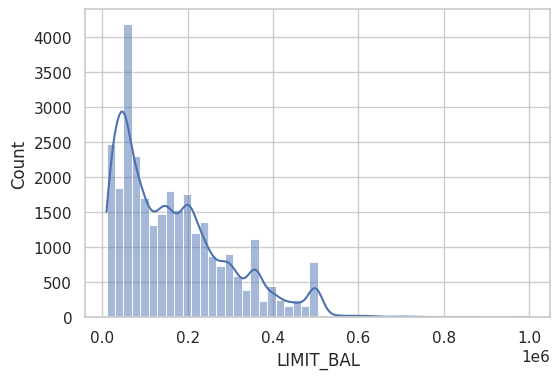

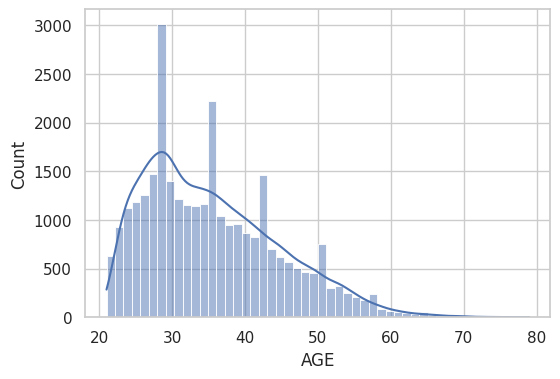

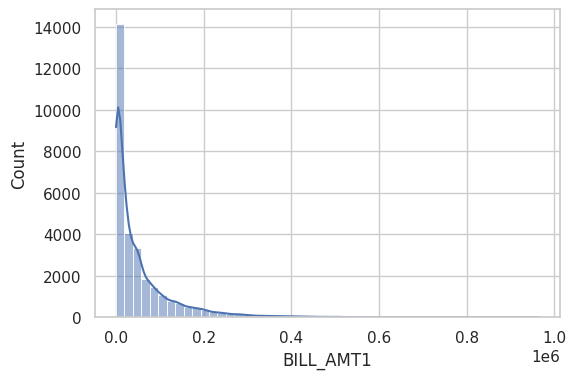

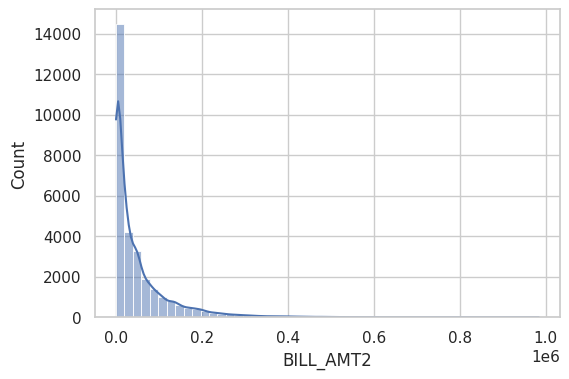

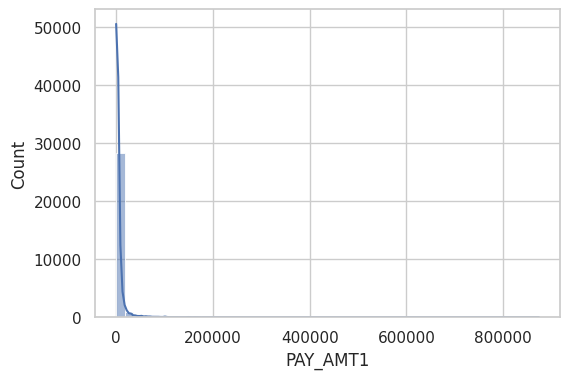

In [59]:
# Строим гистограммы для ключевых признаков:
# лимит кредитной линии, возраст и суммы за первые периоды.
# Это позволяет визуально оценить распределения и наличие выбросов.

cols_to_plot = ['LIMIT_BAL', 'AGE'] + bill_cols[:2] + ['PAY_AMT1']

for col in cols_to_plot:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], bins=50, kde=True)
    plt.show()


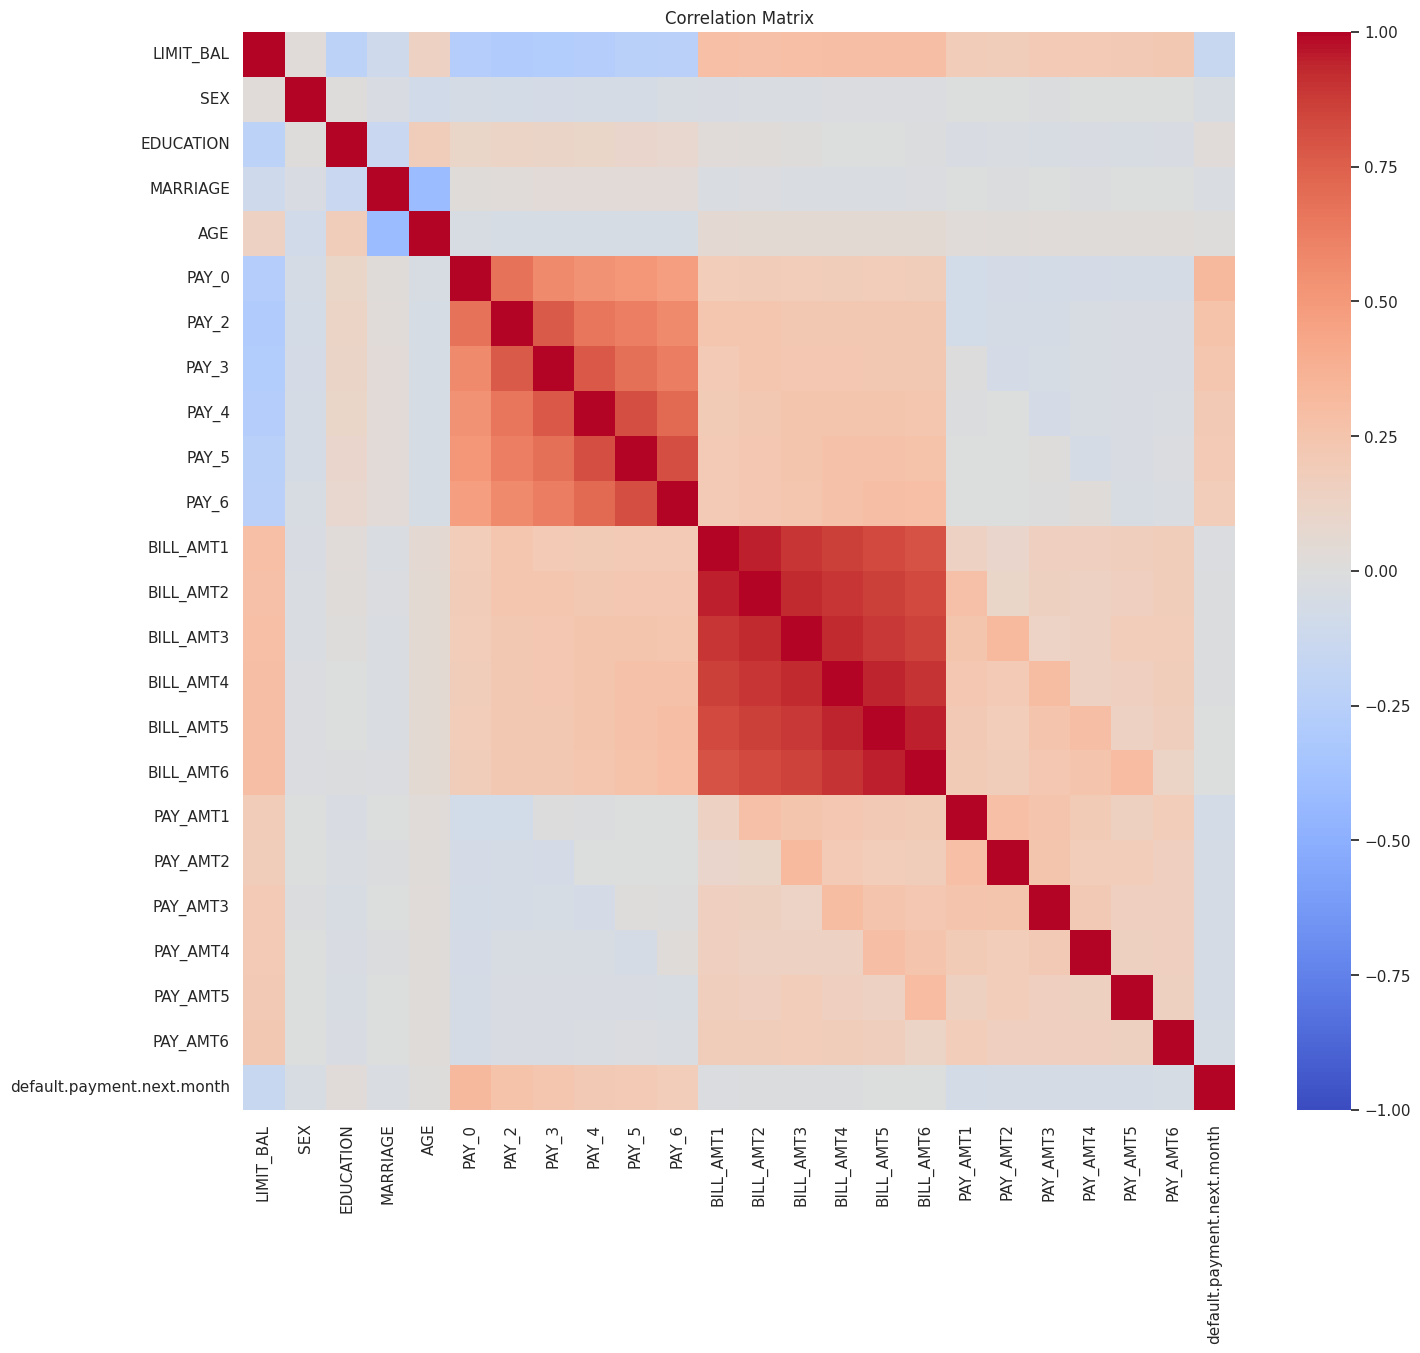

In [60]:
# Строим матрицу корреляций, чтобы понять зависимость
# между финансовыми показателями клиента.
# Полезно для выбора признаков и понимания структуры данных.

plt.figure(figsize=(16,14))
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()


In [61]:
# Разделяем X и y: целевая переменная - default.payment.next.month.
# Категориальные признаки кодируем OneHotEncoder.
# Числовые - нормируем StandardScaler.
# ColumnTransformer позволяет собрать всё в единую матрицу признаков.

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

y = df['default.payment.next.month']
X = df.drop(columns=['default.payment.next.month'])

categorical = ['SEX', 'EDUCATION', 'MARRIAGE']
numerical = [c for c in X.columns if c not in categorical]

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical),
    ('cat', OneHotEncoder(drop='first'), categorical)
])

X_processed = preprocessor.fit_transform(X)
X_processed.shape


(30000, 30)

In [62]:
# Сохраняем обученный препроцессор и очищенный датасет,
# чтобы потом использовать в регрессии и в моделях на других ноутбуках.

import joblib

joblib.dump(preprocessor, 'preprocessor.pkl')
df.to_csv('cleaned_data.csv', index=False)

In [ ]:
# Делим данные на обучающую и тестовую выборки.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

X_train.shape, X_test.shape


((24000, 30), (6000, 30))

In [64]:
# Обучение базовой модели KNN-классификации без подбора гиперпараметров.
# Метрики: Accuracy, Precision, Recall, F1, ROC-AUC.
# Это служит стартовой точкой для сравнения с улучшенной моделью.

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

knn_baseline = KNeighborsClassifier(n_neighbors=5)
knn_baseline.fit(X_train, y_train)

y_pred = knn_baseline.predict(X_test)
y_proba = knn_baseline.predict_proba(X_test)[:,1]

print("=== Baseline KNN ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


=== Baseline KNN ===
Accuracy: 0.7931666666666667
Precision: 0.5501165501165501
Recall: 0.3556895252449133
F1: 0.43203661327231124
ROC AUC: 0.7045082212411372


<Figure size 600x600 with 0 Axes>

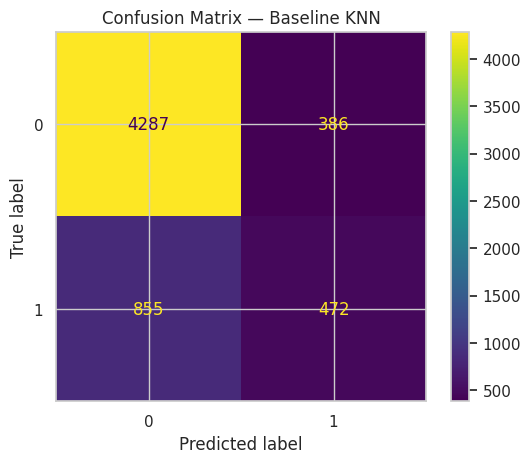

In [65]:
# Визуализируем матрицу ошибок.
# Позволяет увидеть смещение модели: кого чаще ошибочно относим к дефолтным.

from sklearn.metrics import ConfusionMatrixDisplay

plt.figure(figsize=(6,6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix — Baseline KNN")
plt.show()


In [66]:
# Подбираем гиперпараметры KNN:
# - число соседей
# - тип весов
# - метрика расстояния (p=1,2)
# Используем StratifiedKFold + F1 как основную метрику.
# Получаем лучшую модель.

from sklearn.model_selection import GridSearchCV, StratifiedKFold

param_grid = {
    'n_neighbors': [3,5,7,9,11],
    'weights': ['uniform', 'distance'],
    'p': [1,2]   # l1 и l2 расстояния
}

grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)
grid.best_params_, grid.best_score_


Fitting 5 folds for each of 20 candidates, totalling 100 fits


({'n_neighbors': 11, 'p': 2, 'weights': 'uniform'}, 0.44634260311781465)

In [67]:
# Печатаем F1 после.

knn_best = grid.best_estimator_

y_pred_best = knn_best.predict(X_test)
y_proba_best = knn_best.predict_proba(X_test)[:,1]

print("=== Improved KNN ===")
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("Precision:", precision_score(y_test, y_pred_best))
print("Recall:", recall_score(y_test, y_pred_best))
print("F1:", f1_score(y_test, y_pred_best))
print("ROC AUC:", roc_auc_score(y_test, y_proba_best))


=== Improved KNN ===
Accuracy: 0.8046666666666666
Precision: 0.6040268456375839
Recall: 0.33911077618688773
F1: 0.4343629343629344
ROC AUC: 0.7266992266335928


In [68]:
# Печатаем F1 до улучшений
# Улучшенная модель показывает более высокое качество.

print("F1 baseline:", f1_score(y_test, y_pred))
print("F1 improved:", f1_score(y_test, y_pred_best))


F1 baseline: 0.43203661327231124
F1 improved: 0.4343629343629344


In [ ]:
# Реализация собственного KNN для классификации.
# - вычисление расстояний
# - выбор k ближайших соседей
# - голосование по большинству
# Используется как базовый ручной аналог sklearn KNN.

import numpy as np

class MyKNN:
    def __init__(self, n_neighbors=5, p=2):
        self.n = n_neighbors
        self.p = p

    def fit(self, X, y):
        # конвертируем в numpy, чтобы не было pandas-приколов
        self.X = np.asarray(X)
        self.y = np.asarray(y)

    def predict(self, X_test):
        X_test = np.asarray(X_test)
        preds = []

        for x in X_test:
            dist = np.linalg.norm(self.X - x, ord=self.p, axis=1)
            idx = np.argsort(dist)[:self.n]
            votes = self.y[idx]
            vals, counts = np.unique(votes, return_counts=True)
            preds.append(vals[np.argmax(counts)])
        return np.array(preds)


In [78]:
# Чтобы ускорить вычисления, берём случайную подвыборку из 5000 точек.
# Обучаем и тестируем собственный KNN на небольшой части данных.
# Сравниваем Accuracy и F1.

idx = np.random.choice(len(X_train), 5000, replace=False)

myknn = MyKNN(n_neighbors=5)
myknn.fit(X_train[idx], y_train.iloc[idx].to_numpy())

y_pred_my = myknn.predict(X_test[:500])
print("Accuracy (MyKNN):", accuracy_score(y_test[:500], y_pred_my))
print("F1 (MyKNN):", f1_score(y_test[:500], y_pred_my))

Accuracy (MyKNN): 0.766
F1 (MyKNN): 0.4236453201970443


In [79]:
# Добавляем улучшения аналогично sklearn:
# - возможность weighted voting (вес = 1 / dist)
# - выбор метрики p
# Реализация полностью повторяет идею улучшенного baseline.

import numpy as np

class MyImprovedKNN:
    def __init__(self, n_neighbors=5, p=2, weights='uniform'):
        self.n = n_neighbors
        self.p = p
        self.weights = weights

    def fit(self, X, y):
        self.X = np.asarray(X)
        self.y = np.asarray(y)

    def predict(self, X_test):
        X_test = np.asarray(X_test)
        preds = []

        for x in X_test:
            dist = np.linalg.norm(self.X - x, ord=self.p, axis=1)

            idx = np.argsort(dist)[:self.n]
            neighbors = self.y[idx]
            dists = dist[idx]

            if self.weights == 'uniform':
                # обычное голосование
                vals, counts = np.unique(neighbors, return_counts=True)
                preds.append(vals[np.argmax(counts)])
            else:
                # weighted voting
                weights = 1 / (dists + 1e-5)
                w0 = weights[neighbors == 0].sum()
                w1 = weights[neighbors == 1].sum()
                preds.append(1 if w1 > w0 else 0)

        return np.array(preds)


In [86]:
# Обучаем улучшенный KNN на подвыборке.
# Используем лучшие параметры, найденные ранее: (k=11, p=2, weights='uniform').

idx = np.random.choice(len(X_train), 5000, replace=False)

my_imp_knn = MyImprovedKNN(n_neighbors=11, p=2, weights='uniform')
my_imp_knn.fit(X_train[idx], y_train.iloc[idx].to_numpy())

y_pred_my_imp = my_imp_knn.predict(X_test[:500])


In [87]:
# Считаем Accuracy и F1 для улучшенной самописной модели.
# Улучшения действительно дают более высокий F1.

print("Accuracy (MyImprovedKNN):", accuracy_score(y_test[:500], y_pred_my_imp))
print("F1 (MyImprovedKNN):", f1_score(y_test[:500], y_pred_my_imp))


Accuracy (MyImprovedKNN): 0.792
F1 (MyImprovedKNN): 0.4526315789473684
